# Final Project

## Available Assets for Portfolio Optimization
Here is a list of the available assets to consider in the portfolio:

<table>
  <thead>
    <tr>
      <th>Fund Name</th>
      <th>Ticker</th>
      <th>Inception Date</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>JPMorgan Equity Income Fund - Class R6</td>
      <td><a href="https://finance.yahoo.com/quote/OIEJX/history/" target="_blank">OIEJX</a></td>
      <td>Jan 31, 2012</td>
    </tr>
    <tr>
      <td>State Street Equity 500 Index K</td>
      <td><a href="https://finance.yahoo.com/quote/SSSYX/history/" target="_blank">SSSYX</a></td>
      <td>Sep 18, 2014</td>
    </tr>
    <tr>
      <td>T. Rowe Price Dividend Growth</td>
      <td><a href="https://finance.yahoo.com/quote/PRDGX/history/" target="_blank">PRDGX</a></td>
      <td>Dec 31, 1992</td>
    </tr>
    <tr>
      <td>American Funds Growth Fund of Amer R6</td>
      <td><a href="https://finance.yahoo.com/quote/RGAGX/history/" target="_blank">RGAGX</a></td>
      <td>May 1, 2009</td>
    </tr>
    <tr>
      <td>Vanguard Mid Cap Index Admiral</td>
      <td><a href="https://finance.yahoo.com/quote/VIMAX/history/" target="_blank">VIMAX</a></td>
      <td>Nov 12, 2001</td>
    </tr>
    <tr>
      <td>Vanguard Small Cap Value Index Admiral</td>
      <td><a href="https://finance.yahoo.com/quote/VSIAX/history/" target="_blank">VSIAX</a></td>
      <td>Sep 27, 2011</td>
    </tr>
  </tbody>
</table>

Historical data for these assets can be found on [Yahoo Finance website](https://finance.yahoo.com)

Since the portfolio optimization problem requires grouping the time series of each asset into matrix $R$, they must be considered during the same periods. For this reason, only returns starting from the most restrictive case are considered, i.e., **from Sep 18, 2014 until Aug 27, 2025**.

Data sources:
<table>
  <thead>
    <tr>
      <th>Ticker</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><a href="https://finance.yahoo.com/quote/OIEJX/history/?period1=1410998400&period2=1756339200" target="_blank">OIEJX</a></td>
    </tr>
    <tr>
      <td><a href="https://finance.yahoo.com/quote/SSSYX/history/?period1=1410998400&period2=1756339200" target="_blank">SSSYX</a></td>
    </tr>
    <tr>
      <td><a href="https://finance.yahoo.com/quote/PRDGX/history/?period1=1410998400&period2=1756339200" target="_blank">PRDGX</a></td>
    </tr>
    <tr>
      <td><a href="https://finance.yahoo.com/quote/RGAGX/history/?period1=1410998400&period2=1756339200" target="_blank">RGAGX</a></td>
    </tr>
    <tr>
      <td><a href="https://finance.yahoo.com/quote/VIMAX/history/?period1=1410998400&period2=1756339200" target="_blank">VIMAX</a></td>
    </tr>
    <tr>
      <td><a href="https://finance.yahoo.com/quote/VSIAX/history/?period1=1410998400&period2=1756339200" target="_blank">VSIAX</a></td>
    </tr>
  </tbody>
</table>

The service is behind a paywall since early 2025, but data is still accessible inspecting the html elements of the page.

In [ ]:
# Import necessary libraries
import os
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import cvxpy as cp
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Ingestion

In [2]:
def load_html_to_df(html_file):
    """
    Reads a Yahoo Finance HTML file and returns a cleaned pandas DataFrame.
    The columns (except 'date') are automatically prefixed with the file name.
    """
    with open(html_file, 'r') as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, 'lxml')
    table_rows = soup.find_all('tr')

    data = []
    for row in table_rows:
        row_data = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
        if row_data:
            data.append(row_data)

    columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
    df = pd.DataFrame(data, columns=columns)
    df['date'] = pd.to_datetime(df['date'])

    prefix = os.path.splitext(os.path.basename(html_file))[0]
    # Rename columns except 'date' by prefixing with the file name
    df.columns = ['date'] + [f"{prefix}_{col}" for col in columns[1:]]

    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')
    df = df.sort_values('date', ascending=True).reset_index(drop=True)
    
    return df

In [3]:
oiejx = load_html_to_df('../data/oiejx.html')
sssyx = load_html_to_df('../data/sssyx.html')
prdgx = load_html_to_df('../data/prdgx.html')
rgagx = load_html_to_df('../data/rgagx.html')
vimax = load_html_to_df('../data/vimax.html')
vsiax = load_html_to_df('../data/vsiax.html')

## Exploratory Data Analysis

In [4]:
sssyx

,date,sssyx_open,sssyx_high,sssyx_low,sssyx_close,sssyx_adj_close,sssyx_volume
0,2014-09-18,170.899994,170.899994,170.899994,170.899994,126.000000,NaN
1,2014-09-19,170.800003,170.800003,170.800003,170.800003,125.930000,NaN
2,2014-09-22,169.399994,169.399994,169.399994,169.399994,124.900002,NaN
3,2014-09-23,168.500000,168.500000,168.500000,168.500000,124.230003,NaN
4,2014-09-24,169.800003,169.800003,169.800003,169.800003,125.190002,NaN
...,...,...,...,...,...,...,...
2766,2025-08-21,479.130005,479.130005,479.130005,479.130005,479.130005,NaN
2767,2025-08-22,486.440002,486.440002,486.440002,486.440002,486.440002,NaN
2768,2025-08-25,484.369995,484.369995,484.369995,484.369995,484.369995,NaN
2769,2025-08-26,486.399994,486.399994,486.399994,486.399994,486.399994,NaN


We can see that all columns are actually the same value. This is because mutual funds are priced once per day at their net asset value (NAV), not traded during the day like stocks. Since there’s only one price, data providers copy the NAV into all fields (open, high, low, close, adj close), and volume is usually zero or blank.

In [5]:
sssyx.info()
sssyx.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2771 non-null   datetime64[ns]
 1   sssyx_open       2752 non-null   float32       
 2   sssyx_high       2752 non-null   float32       
 3   sssyx_low        2752 non-null   float32       
 4   sssyx_close      2752 non-null   float32       
 5   sssyx_adj_close  2752 non-null   float32       
 6   sssyx_volume     0 non-null      float32       
dtypes: datetime64[ns](1), float32(6)
memory usage: 86.7 KB


,date,sssyx_open,sssyx_high,sssyx_low,sssyx_close,sssyx_adj_close,sssyx_volume
count,2771,2752.000000,2752.000000,2752.000000,2752.000000,2752.000000,0.0
mean,2020-03-06 18:55:59.653554688,271.758911,271.758911,271.758911,271.758911,244.565323,NaN
min,2014-09-18 00:00:00,154.000000,154.000000,154.000000,154.000000,116.860001,NaN
25%,2017-06-14 12:00:00,202.100006,202.100006,202.100006,202.100006,159.970001,NaN
50%,2020-03-09 00:00:00,242.250000,242.250000,242.250000,242.250000,215.054993,NaN
75%,2022-11-28 12:00:00,331.987518,331.987518,331.987518,331.987518,313.332489,NaN
max,2025-08-27 00:00:00,487.559998,487.559998,487.559998,487.559998,487.559998,NaN
std,NaN,85.183502,85.183502,85.183502,85.183502,98.743935,NaN


## Preprocessing

### Feature selection
Since we only need one column, we'll just keep the first one.

In [6]:
oiejx = oiejx.iloc[:, :2]
sssyx = sssyx.iloc[:, :2]
prdgx = prdgx.iloc[:, :2]
rgagx = rgagx.iloc[:, :2]
vimax = vimax.iloc[:, :2]
vsiax = vsiax.iloc[:, :2]

In [7]:
sssyx

,date,sssyx_open
0,2014-09-18,170.899994
1,2014-09-19,170.800003
2,2014-09-22,169.399994
3,2014-09-23,168.500000
4,2014-09-24,169.800003
...,...,...
2766,2025-08-21,479.130005
2767,2025-08-22,486.440002
2768,2025-08-25,484.369995
2769,2025-08-26,486.399994


### Cleaning
Inspecting the missing values, we can see that those really happen at the end of the year, where dividends are usually distributed.

In [8]:
sssyx[sssyx.iloc[:, 1].isna()]['date']

68     2014-12-23
320    2015-12-23
575    2016-12-23
826    2017-12-22
828    2017-12-22
1081   2018-12-27
1083   2018-12-27
1336   2019-12-27
1337   2019-12-27
1414   2020-04-20
1591   2020-12-29
1593   2020-12-29
1844   2021-12-28
1845   2021-12-28
2098   2022-12-27
2099   2022-12-27
2349   2023-12-26
2351   2023-12-26
2604   2024-12-26
Name: date, dtype: datetime64[ns]

In [9]:
sssyx.iloc[1590:1595, :]

,date,sssyx_open
1590,2020-12-28,290.700012
1591,2020-12-29,NaN
1592,2020-12-29,284.700012
1593,2020-12-29,NaN
1594,2020-12-30,285.109985


As we can see, there aren't really missing days. It's actually that there are multiple entries for those days. So we can just drop NaN values.

In [10]:
oiejx.dropna(inplace=True)
sssyx.dropna(inplace=True)
prdgx.dropna(inplace=True)
rgagx.dropna(inplace=True)
vimax.dropna(inplace=True)
vsiax.dropna(inplace=True)
sssyx

,date,sssyx_open
0,2014-09-18,170.899994
1,2014-09-19,170.800003
2,2014-09-22,169.399994
3,2014-09-23,168.500000
4,2014-09-24,169.800003
...,...,...
2766,2025-08-21,479.130005
2767,2025-08-22,486.440002
2768,2025-08-25,484.369995
2769,2025-08-26,486.399994


### Transformation of variables
Next we need to calculate the fractional returns over every period. Since we're dealing with mutual funds, for a given asset $j$:

$R_{t,j}$ is computed as $\frac{Open_{t,j} - Open_{t-1,j}}{Open_{t-1,j}}$, that is the percent change of asset $j$ from period $t-1$ to $t$.

In [11]:
oiejx['oiejx_return'] = oiejx['oiejx_open'].pct_change()
oiejx

,date,oiejx_open,oiejx_return
0,2014-09-18,14.070000,NaN
1,2014-09-19,14.080000,0.000711
2,2014-09-22,13.970000,-0.007812
3,2014-09-23,13.880000,-0.006442
4,2014-09-24,13.970000,0.006484
...,...,...,...
2885,2025-08-21,25.850000,-0.001930
2886,2025-08-22,26.190001,0.013153
2887,2025-08-25,26.030001,-0.006109
2888,2025-08-26,26.110001,0.003073


In [12]:
sssyx['sssyx_return'] = sssyx['sssyx_open'].pct_change()
prdgx['prdgx_return'] = prdgx['prdgx_open'].pct_change()
rgagx['rgagx_return'] = rgagx['rgagx_open'].pct_change()
vimax['vimax_return'] = vimax['vimax_open'].pct_change()
vsiax['vsiax_return'] = vsiax['vsiax_open'].pct_change()

Drop the first value, as there is no percent change for that case.

In [13]:
oiejx.dropna(inplace=True)
sssyx.dropna(inplace=True)
prdgx.dropna(inplace=True)
rgagx.dropna(inplace=True)
vimax.dropna(inplace=True)
vsiax.dropna(inplace=True)
sssyx

,date,sssyx_open,sssyx_return
1,2014-09-19,170.800003,-0.000585
2,2014-09-22,169.399994,-0.008197
3,2014-09-23,168.500000,-0.005313
4,2014-09-24,169.800003,0.007715
5,2014-09-25,167.100006,-0.015901
...,...,...,...
2766,2025-08-21,479.130005,-0.003888
2767,2025-08-22,486.440002,0.015257
2768,2025-08-25,484.369995,-0.004255
2769,2025-08-26,486.399994,0.004191


Finally, we just need to confirm how many days of available data are there every year.

In [14]:
sssyx['date'].dt.year.value_counts()

date
2020    253
2015    252
2016    252
2019    252
2021    252
2024    252
2017    251
2018    251
2022    251
2023    250
2025    163
2014     72
Name: count, dtype: int64

### Merging the datasets
Extracting the returns for all assets and putting them into the matrix R

In [15]:
# Merge all dataframes on 'date' and keep only the return columns for each
returns_df = oiejx[['date', 'oiejx_return']] \
    .merge(sssyx[['date', 'sssyx_return']], on='date', how='inner') \
    .merge(prdgx[['date', 'prdgx_return']], on='date', how='inner') \
    .merge(rgagx[['date', 'rgagx_return']], on='date', how='inner') \
    .merge(vimax[['date', 'vimax_return']], on='date', how='inner') \
    .merge(vsiax[['date', 'vsiax_return']], on='date', how='inner')

returns_df.reset_index(drop=True, inplace=True)
returns_df

,date,oiejx_return,sssyx_return,prdgx_return,rgagx_return,vimax_return,vsiax_return
0,2014-09-19,0.000711,-0.000585,-0.001392,-0.000214,-0.002881,-0.007562
1,2014-09-22,-0.007812,-0.008197,-0.006689,-0.011536,-0.010750,-0.013671
2,2014-09-23,-0.006442,-0.005313,-0.005892,-0.005403,-0.006927,-0.009316
3,2014-09-24,0.006484,0.007715,0.007338,0.010430,0.007318,0.004587
4,2014-09-25,-0.014316,-0.015901,-0.014010,-0.015484,-0.013918,-0.013699
...,...,...,...,...,...,...,...
2746,2025-08-21,-0.001930,-0.003888,-0.003582,-0.003448,-0.003664,-0.001834
2747,2025-08-22,0.013153,0.015257,0.009466,0.019446,0.018698,0.031921
2748,2025-08-25,-0.006109,-0.004255,-0.007596,-0.004213,-0.007470,-0.006899
2749,2025-08-26,0.003073,0.004191,0.004066,0.006934,0.002210,0.003249


Let's add a risk-free asset in the last column, representing cash growing at a certain fixed rate.

Consider an Annual Percentage Yield of 4%, which translated into daily returns becomes approximately $0.0107 \%$. Computed as:
\begin{align*}
  R_{tj} = (1 + APY)^{1/365} - 1
\end{align*}

where $j = n$, meaning, the last column.

In [16]:
APY = 0.038
muRF = (1+APY)**(1/365) - 1

print(f"Daily return of risk-free asset: {muRF*100:.4f}%")

Daily return of risk-free asset: 0.0102%


In [17]:
returns_df['risk_free_return'] = muRF

Finally, let's create 2 R matrices, one without the cash asset and and with it.

In [18]:
R = returns_df.iloc[:,1:-1].values
R_rf = returns_df.iloc[:,1:].values

## Constrained Least Squares Problem
The optimal solution is:
\begin{align}
    \begin{bmatrix}w\\z_1\\z_2\end{bmatrix} =
    \begin{bmatrix}
        2R^TR & \textbf{1} & \mu\\
        \textbf{1}^T & 0 & 0\\
        \mu^T & 0 & 0
    \end{bmatrix}^{-1} \begin{bmatrix}
        2\rho T\mu\\
        1\\
        \rho
    \end{bmatrix}
\end{align}

The following function finds the optimal allocation weights for the desired portfolio return $\rho$, and thus the portfolio risk . Using it to compute the weights for several $\rho$ values, and obtain their associated risk values.

**We choose to give the input in annualized and percentage form**, that is, the desired return after 1 year. The function then converts it to $\rho$ appropriately.

Examples:
* `desired_annualized_return = 10` represents a desired 10% return for the year. So if the invested capital is $100, at the end of the year, the expected return is $10, for a total os $110 in assets.

* `desired_annualized_return = 100` represents a desired 100% return for the year. So if the invested capital is $100, at the end of the year, the expected return is $100, for a total os $200 in assets.

Additionally, the **function returns the risk in annualized and percentage form**.

**There are approximately 251 trading days in a year in U.S. markets**. See this [source](https://en.wikipedia.org/wiki/Trading_day)

In [19]:
def compute_annualized_risk(desired_annualized_return=10, has_risk_free=False):

    if not has_risk_free:
        R_matrix = R
    else:
        R_matrix = R_rf

    T, n = R_matrix.shape
    mu = np.mean(R_matrix, axis=0)
    
    # Convert annualized percentage return to daily return
    trading_days = 251
    rho = (1 + desired_annualized_return * 0.01)**(1/trading_days) - 1

    RTR = 2 * R_matrix.T @ R_matrix
    ones_col = np.ones((n, 1))
    ones_row = np.ones((1, n))
    mu_col = mu.reshape(-1, 1)
    mu_row = mu.reshape(1, -1)

    A = np.block([
        [RTR,      ones_col, mu_col],
        [ones_row, 0,        0     ],
        [mu_row,   0,        0     ]
    ])
    b = np.concatenate([2 * rho * T * mu, [1], [rho]])
    solution = np.linalg.inv(A) @ b

    w = solution[:n] # The other values are the Lagrange multipliers
    
    # Annualize the daily volatility: multiply by sqrt(trading_days)
    annualized_risk = np.sqrt(trading_days) * np.std(R_matrix @ w) * 100

    return w, annualized_risk

Computing portfolio annualized risk with**OUT** cash

In [20]:
# Build an array of desired annualized percentage returns
annualized_returns = np.arange(1, 101, 0.1)

# Compute risks for each desired return, and unpack the results
annualized_risks = np.empty_like(annualized_returns)
for i, desired_return in enumerate(annualized_returns):
    _, annualized_risk = compute_annualized_risk(desired_annualized_return=desired_return)
    annualized_risks[i] = annualized_risk

Computing portfolio annualized risk **WITH** cash

In [21]:
annualized_risks_rf = np.empty_like(annualized_returns)
for i, desired_return in enumerate(annualized_returns):
    _, annualized_risk = compute_annualized_risk(desired_annualized_return=desired_return, has_risk_free=True)
    annualized_risks_rf[i] = annualized_risk

In [22]:
def plot_risk_return(risks, returns):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=risks,
        y=returns,
        mode='markers',
        marker=dict(size=8),
    ))
    fig.update_layout(
        xaxis_title='Annualized Risk (%)',
        yaxis_title='Annualized Return (%)',
        title='Risk-Return Tradeoff'
    )
    fig.update_layout(
        height=500,
    ).show()

plot_risk_return(annualized_risks, annualized_returns)
plot_risk_return(annualized_risks_rf, annualized_returns)

Plot for the written document:

Tangency point

In [23]:
# Tangency point (closest approach) between the two curves
idx = np.argmin(np.abs(annualized_risks - annualized_risks_rf))
print(f"Tangency risk: {annualized_risks[idx]:.2f}%  |  With cash: {annualized_risks_rf[idx]:.2f}%")
print(f"Tangency return: {annualized_returns[idx]:.2f}%")

Tangency risk: 41.56%  |  With cash: 41.56%
Tangency return: 43.20%


Return and Risk with equal distribution among all assets, without cash:

In [24]:
trading_days = 251
R_matrix = R
weights = np.ones(R_matrix.shape[1]) / R_matrix.shape[1]
print("Weights:", np.round(weights, 4))
print(f"Return: {trading_days * np.mean(R_matrix @ weights) * 100:.2f}%")
print(f"Risk: {np.sqrt(trading_days) * np.std(R_matrix @ weights) * 100:.2f}%")


Weights: [0.1667 0.1667 0.1667 0.1667 0.1667 0.1667]
Return: 8.93%
Risk: 17.73%


Return and Risk with equal distribution among all assets, including cash:

In [25]:
trading_days = 251
R_matrix = R_rf
weights = np.ones(R_matrix.shape[1]) / R_matrix.shape[1]
print("Weights:", np.round(weights, 4))
print(f"Return: {trading_days * np.mean(R_matrix @ weights) * 100:.2f}%")
print(f"Risk: {np.sqrt(trading_days) * np.std(R_matrix @ weights) * 100:.2f}%")


Weights: [0.1429 0.1429 0.1429 0.1429 0.1429 0.1429 0.1429]
Return: 8.02%
Risk: 15.20%


Plotting the points with equal allocation

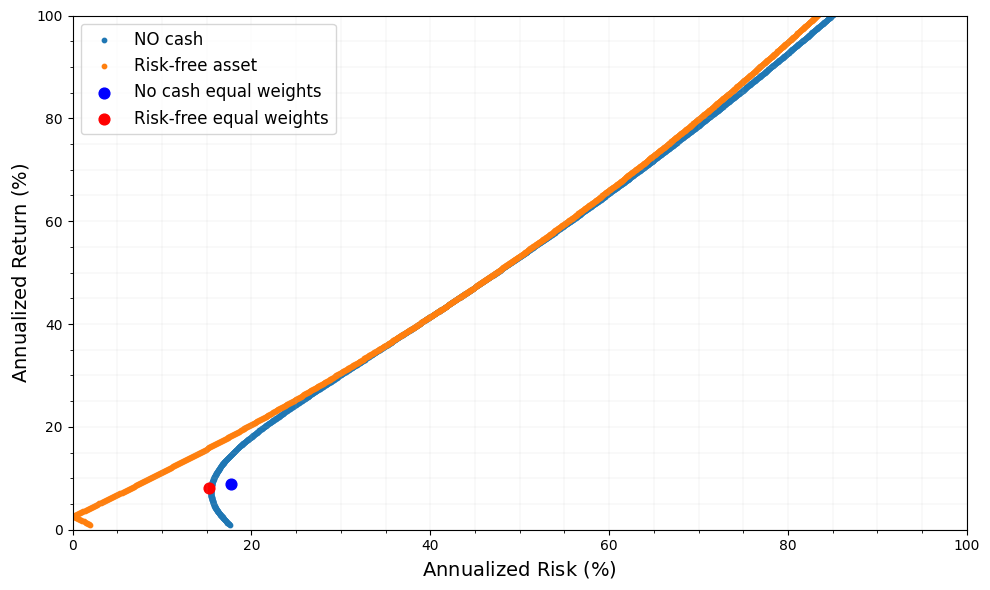

In [26]:
no_cash_point = [17.73, 8.93]
cash_point = [15.20, 8.02]

plt.figure(figsize=(10, 6))
plt.scatter(annualized_risks, annualized_returns, s=10, label="NO cash")
plt.scatter(annualized_risks_rf, annualized_returns, s=10, label="Risk-free asset")
plt.scatter(no_cash_point[0], no_cash_point[1], color='blue', s=60, marker='o', label="No cash equal weights")
plt.scatter(cash_point[0], cash_point[1], color='red', s=60, marker='o', label="Risk-free equal weights")
plt.xlabel(r'Annualized Risk $(\%)$', fontsize=14)
plt.ylabel(r'Annualized Return $(\%)$', fontsize=14)
plt.minorticks_on()
plt.grid(which='minor', linestyle='-', linewidth=0.1)
plt.grid(which='major', linestyle='-', linewidth=0.1)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Choosing one sample return with cash

In [27]:
weights, risk = compute_annualized_risk(desired_annualized_return=20, has_risk_free=True)
print("Weights:", np.round(weights, 4))
print(f"Risk: {risk:.2f}%")
leverage = np.sum(np.abs(weights))
print(f"Leverage: {leverage:.2f}")

Weights: [-2.8846  2.2291  1.7324 -1.2414  0.5536  0.0808  0.5301]
Risk: 19.52%
Leverage: 9.25


## Optimization
Solving the optimization problem with CVXPY and comparing it to the LS solution for a single desired annualized return

In [28]:
desired_annualized_return = 20

In [29]:
R_matrix = R_rf
T, n = R_matrix.shape

# Compute average return per asset
mu = np.mean(R_matrix, axis=0)  # Shape: (n,)

# Convert annualized percentage return to daily return
trading_days = 251
rho = (1 + desired_annualized_return * 0.01)**(1/trading_days) - 1

# Define optimization variable
w = cp.Variable(n)

# Define constraints
constraints = [
    cp.sum(w) == 1,       # weights sum to 1
    mu @ w == rho         # target average return
]

# Define the objective (least squares formulation)
objective = cp.Minimize(cp.norm(R_matrix @ w - rho, 2))

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Output results
print("Optimal weights w:", w.value)
print("Achieved average return:", trading_days * mu.T @ w.value * 100)
print("Portfolio risk (std dev of returns):", np.sqrt(trading_days) * np.std(R_matrix @ w.value) * 100)


Optimal weights w: [-2.88462098  2.22911244  1.73235646 -1.24136771  0.55361018  0.08075972
  0.53014988]
Achieved average return: 18.238779026029103
Portfolio risk (std dev of returns): 19.523576599353692


In [30]:
weights, risk = compute_annualized_risk(desired_annualized_return=desired_annualized_return)
print(f"Weights: {weights}")
print(f"Risk: {risk:.2f}%")

Weights: [-2.00085791  1.6810483   2.10057449 -0.94735404  0.30035909 -0.13376993]
Risk: 21.43%


As expected, the same values are obtained with the Linear Algebra LS solution and CVXPY.